In [14]:
import cv2
import librosa
import mediapipe as mp
import numpy as np
from IPython.display import clear_output
from moviepy import VideoFileClip
import matplotlib.pyplot as plt
import math
import os
from scipy.stats import spearmanr
import tempfile
import warnings
from scipy.spatial import distance as dist
from scipy.signal import find_peaks
warnings.filterwarnings("ignore", category=FutureWarning, module="librosa")

In [15]:
# Calculate the Eye Aspect Ratio (EAR)
def eye_aspect_ratio(eye_landmarks):
    # Compute the Euclidean distances between the vertical eye landmarks
    A = dist.euclidean(eye_landmarks[1], eye_landmarks[5])
    B = dist.euclidean(eye_landmarks[2], eye_landmarks[4])
    # Compute the Euclidean distance between the horizontal eye landmarks
    C = dist.euclidean(eye_landmarks[0], eye_landmarks[3])
    # Compute the eye aspect ratio
    ear = (A + B) / (C)
    return ear
def mouth_aspect_ratio(mouth_landmarks):
    # Compute the Euclidean distances between the vertical eye landmarks
    A = dist.euclidean(mouth_landmarks[1], mouth_landmarks[5])
    B = dist.euclidean(mouth_landmarks[2], mouth_landmarks[4])
    # Compute the Euclidean distance between the horizontal eye landmarks
    C = dist.euclidean(mouth_landmarks[0], mouth_landmarks[3])
    # Compute the eye aspect ratio
    mar = (A + B) / (C)
    return mar
def extract_video_features(video_path):
    """Extracts lip landmarks from the video using MediaPipe."""
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)
    cap = cv2.VideoCapture(video_path)
    # Get video frame rate using OpenCV    
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second    

    MOUTH_OPEN = 0 # OPEN = 0 and CLOSED = 1
    speak_count = 0 # Total number of mouth open and close detected    

    # Landmark indices for upper and lower lips
    upper_lip_points = [185,40,39,37,0,267,269,270,409]
    lower_lip_points = [146,91,181,84,17,314,405,321,375]    
    MOUTH_INDICES = [185,37,267,409,314,84]
    MAR_THRESHOLD = 1.25
    # Variables for blink detection
    EYE_STATUS = 0  # OPEN = 0 and CLOSED = 1
    blink_count = 0  # Total number of blinks detected
    EAR = 0
    EAR_THRESHOLD = 0.4  # Eye aspect ratio threshold for blink detection    
    # Landmark indices for left and right eyes
    LEFT_EYE_INDICES = [362, 385, 387, 263, 373, 380]
    RIGHT_EYE_INDICES = [33, 160, 158, 133, 153, 144]
    lip_features = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(frame_rgb)
        if results.multi_face_landmarks:
            for landmarks in results.multi_face_landmarks:                           
                # face_width = math.sqrt((landmarks.landmark[323].x - landmarks.landmark[93].x)**2 + (landmarks.landmark[323].y - landmarks.landmark[93].y)**2)
                
                # Lip movement feature extraction
                upper_lips = [(lm.x, lm.y) for i, lm in enumerate(landmarks.landmark) if i in upper_lip_points]
                lower_lips = [(lm.x, lm.y) for i, lm in enumerate(landmarks.landmark) if i in lower_lip_points]
                distances = [math.sqrt((ul[0] - ll[0])**2 + (ul[1] - ll[1])**2) for ul, ll in zip(upper_lips, lower_lips)]                            
                mouth = []
                for idx in MOUTH_INDICES:
                    landmark = landmarks.landmark[idx]
                    x = int(landmark.x * frame.shape[1])
                    y = int(landmark.y * frame.shape[0])
                    mouth.append((x, y))
                MAR = mouth_aspect_ratio(mouth)
                lip_features.append(distances)
                if MAR > MAR_THRESHOLD:                
                    MOUTH_OPEN = 1
                else:
                    if MOUTH_OPEN == 1:
                        speak_count += 1
                    MOUTH_OPEN = 0
                
                # Eye movement feature extraction                
                # Extract landmarks for left and right eyes
                left_eye = []
                right_eye = []
                for idx in LEFT_EYE_INDICES:
                    landmark = landmarks.landmark[idx]
                    x = int(landmark.x * frame.shape[1])
                    y = int(landmark.y * frame.shape[0])
                    left_eye.append((x, y))
                for idx in RIGHT_EYE_INDICES:
                    landmark = landmarks.landmark[idx]
                    x = int(landmark.x * frame.shape[1])
                    y = int(landmark.y * frame.shape[0])
                    right_eye.append((x, y))

                # Calculate EAR for both eyes
                left_ear = eye_aspect_ratio(left_eye)
                right_ear = eye_aspect_ratio(right_eye)
                EAR = (left_ear + right_ear) / 2.0
                
                if EAR < EAR_THRESHOLD:
                    EYE_STATUS = 1                    
                else:
                    if EYE_STATUS == 1:
                        blink_count += 1
                    EYE_STATUS = 0                    
    cap.release()
    return lip_features,blink_count,speak_count, fps
def extract_audio_from_video(video_path):
    video_clip = VideoFileClip(video_path)
    audio = video_clip.audio
    with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as temp_audio:
        audio.write_audiofile(temp_audio.name)
        return temp_audio.name
def get_audio_energy(video_path,fps):
    audio_path = extract_audio_from_video(video_path)
    # Load audio using librosa
    y, sr = librosa.load(audio_path, sr=16000, mono=True)        
    
    # Calculate hop_length and frame_length to match video frames
    hop_length = int(sr / fps)  # Hop length to match video frame rate
    frame_length = int(sr * 0.05)  # 50ms window (can be adjusted)
    
    # Calculate short-time energy
    energy = np.array([
        sum(abs(y[i:i+frame_length])**2)
        for i in range(0, len(y), hop_length)
    ])
    
    return energy
# Min-max normalization function
def min_max_normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
def moving_average(data, window_size):
    # Ensure the window size is odd
    if window_size % 2 == 0:
        raise ValueError("Window size must be odd to maintain symmetry.")
    
    # Create a window of ones and normalize it
    window = np.ones(window_size) / window_size
    
    # Pad the data to handle edges
    pad_size = window_size // 2
    padded_data = np.pad(data, (pad_size, pad_size), mode='edge')  # Reflect padding
    
    # Apply convolution to compute the moving average
    smoothed_data = np.convolve(padded_data, window, mode='valid')
    
    return smoothed_data

In [16]:
def detect_peaks(data):
    # Compute absolute difference between consecutive frames
    movement = np.abs(np.diff(data))
    peaks, _ = find_peaks(movement, height=np.mean(movement) + np.std(movement),
                      prominence=0.05, width=1, distance=2)
    return peaks    

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'mp42', 'minor_version': '1', 'compatible_brands': 'isommp41mp42', 'creation_time': '2025-01-27T11:22:59.000000Z'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 156, 'metadata': {'Metadata': '', 'creation_time': '2025-01-27T11:22:59.000000Z', 'handler_name': 'Core Media Audio', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'video', 'language': None, 'default': True, 'size': [568, 320], 'bitrate': 722, 'fps': 30.0, 'codec_name': 'h264', 'profile': '(Main)', 'metadata': {'Metadata': '', 'creation_time': '2025-01-27T11:22:59.000000Z', 'handler_name': 'Core Media Video', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'displaymatrix': 'rotation of 90.00 degrees'}}, {'input_number': 0, 'stream_number': 2, 'stream_type': 'data', 'language': None, 'default': True, 'metadata': {'Metada

MoviePy - Done.


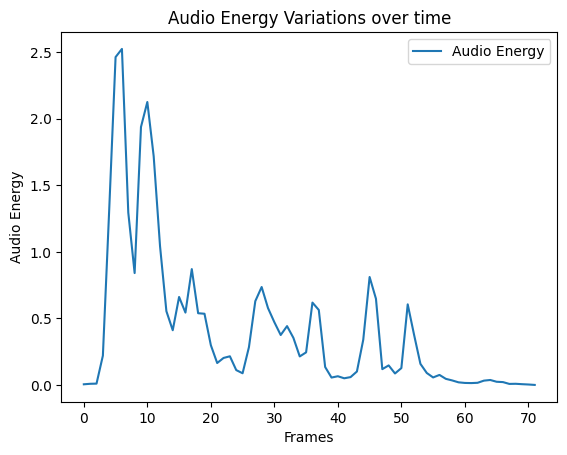

In [21]:
dummy_path = r'D:\Programming\Python\AI\Basics\AMNIL Tech\Liveness Detection\lip_movement\video\real\real1.mp4'
audio_energy = get_audio_energy(dummy_path,30)

normalized_audio = min_max_normalize(audio_energy)
avg_audio = moving_average(normalized_audio, 9)

# Detect Audio Change
audio_changes = len(detect_peaks(audio_energy))
# plt.plot(avg_audio,label='Moving Average Distance',color='r')
plt.plot(audio_energy,label='Audio Energy')
# plt.plot(normalized_audio,label='Normalized Distance',color='Black')
plt.title('Audio Energy Variations over time')
plt.xlabel("Frames")
plt.ylabel("Audio Energy")
plt.legend()

Speak count:  5


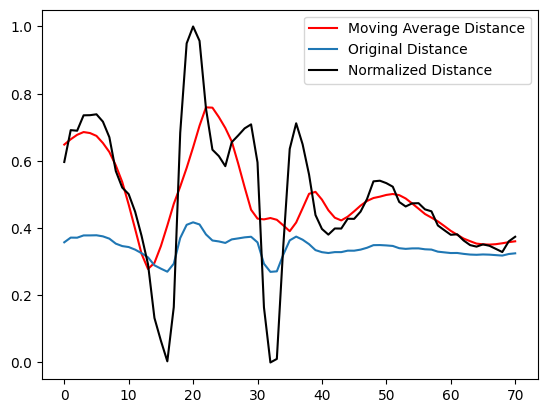

In [29]:
dummy_path = r'D:\Programming\Python\AI\Basics\AMNIL Tech\Liveness Detection\lip_movement\video\real\real1.mp4'
lip_feat,blink_count,speak_count,fps = extract_video_features(dummy_path)

print('Speak count: ',speak_count)
mean_dist = np.sum(lip_feat,axis=1)

normalized_dist = min_max_normalize(mean_dist)
times = np.arange(len(normalized_dist)) / fps
avg_dist = moving_average(normalized_dist, 9)
plt.plot(avg_dist,label='Moving Average Distance',color='r')
plt.plot(mean_dist,label='Original Distance')
plt.plot(normalized_dist,label='Normalized Distance',color='Black')
plt.legend()

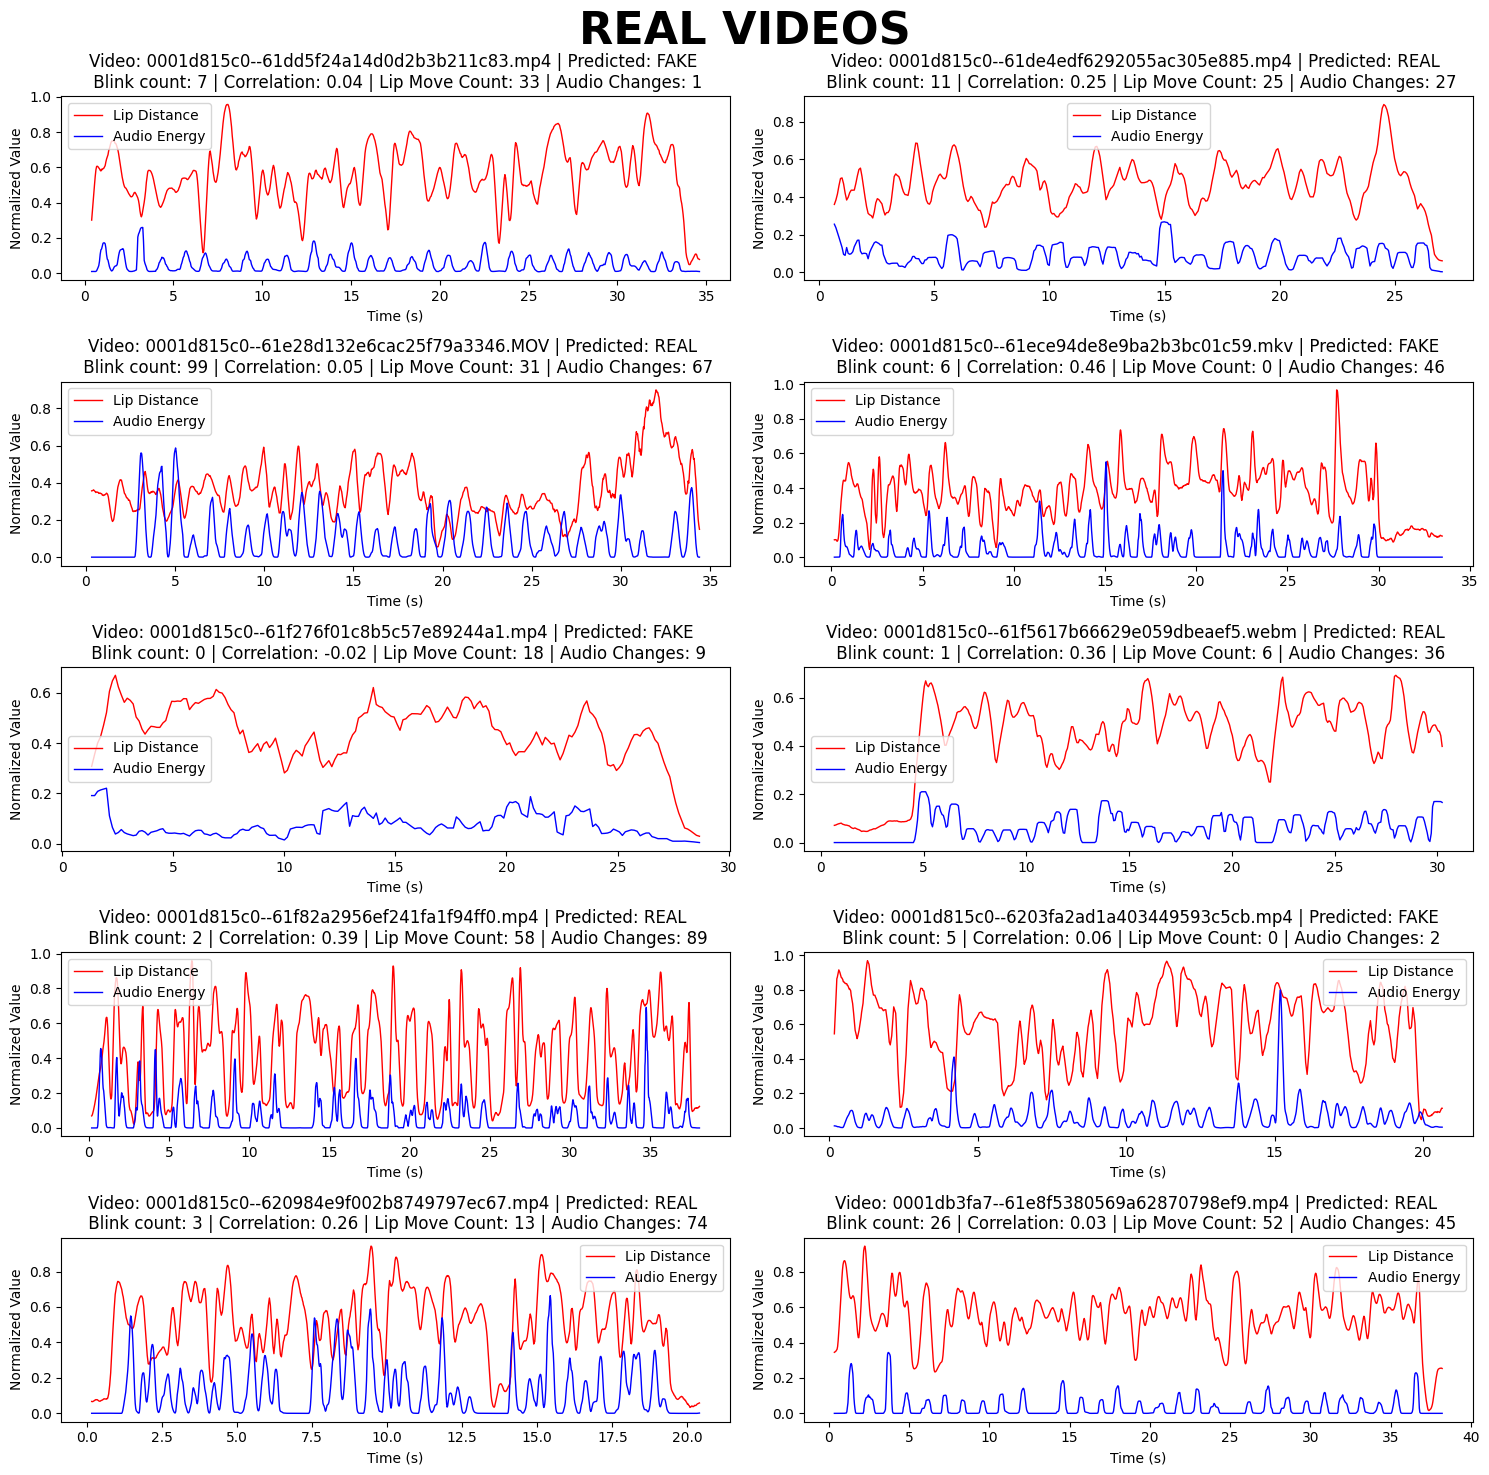

In [26]:
test = 'real'
window_size = 9
#video_folder_path = f'D:/Programming/Python/AI/Basics/AMNIL Tech/Liveness Detection/lip_movement/video/{test}'
video_folder_path = f'C:/Users/aanki/Downloads/live_videos/{test}'
videos = os.listdir(f'{video_folder_path}')
num_plots = len(videos)
# Calculate the grid size (rows, columns)
ncols = 2  # For example, we want 3 columns
nrows = math.ceil(num_plots / ncols)  # Use ceiling to make sure all plots fit

# Create subplots with the calculated grid size
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
fig.suptitle(f"{test} videos".upper(),fontsize=32,fontweight='bold')
# Flatten the axes array to make indexing easier (in case of 2D array of axes)
axes = axes.flatten()
start_delay = 10
#videos = ['fake3.mp4','fake4.mp4','fake7.mp4','fake8.mp4']
for index,video in enumerate(videos):
    video_path = f'{video_folder_path}/{video}'
    # For Video
    print(f'[Processing] Video: {video}')
    print('[INFO] Getting Video features')
    lip_feat,blink_count,speak_count,fps = extract_video_features(video_path)    
    
    #print('Lip Movement detected: ', lip_movement_detected)
    # For Audio
    print('[INFO] Getting Audio features')
    audio_energy = get_audio_energy(video_path,fps)

    #print('Audio Energy detected: ', audio_change_detected)
    mean_dist = np.mean(lip_feat,axis=1)
    min_len = min(len(mean_dist),len(audio_energy))
    normalized_dist = min_max_normalize(mean_dist)[start_delay:min_len]
    normalized_audio = min_max_normalize(audio_energy)[start_delay:min_len]
    times = np.arange(start_delay,min_len) / fps
    avg_dist = moving_average(normalized_dist, window_size)
    avg_audio = moving_average(normalized_audio, window_size)

    # Detect lip movement
    # lip_movements = len(detect_peaks(avg_dist))
    
    # Detect Audio Change
    audio_changes = len(detect_peaks(audio_energy))

    # Calculate Pearson correlation coefficient
    print('[INFO] Calculating Correlation')
    correlation, _ = spearmanr(normalized_dist, normalized_audio)                 
    if not (speak_count>=2 and audio_changes>=2):    
        pred = 'FAKE'
    else:
        if correlation < 0: 
            if correlation > -0.1 and blink_count>0:
                pred = 'REAL'
            else:
                pred = 'FAKE'
        else:
            pred = 'REAL'        
    clear_output(wait=True)
    axes[index].set_title(f"Video: {video} | Predicted: {pred} \n Blink count: {blink_count} | Correlation: {correlation:.2f} | Lip Move Count: {speak_count} | Audio Changes: {audio_changes}")
    axes[index].plot(times, avg_dist, label = "Lip Distance", color ='red',linewidth=1)
    axes[index].plot(times, avg_audio, label="Audio Energy", color='blue', linewidth=1)
    axes[index].legend()
    axes[index].set_xlabel('Time (s)')
    axes[index].set_ylabel('Normalized Value')          
    
plt.tight_layout()